# Getting Stock Prices

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import pi
from pandas.tseries.offsets import MonthEnd

# List of 10 stock tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'JPM', 'BAC']

# Download stock prices from 2022 to 2023 and remove timezone information
price_data = yf.download(tickers, start='2022-01-01', end='2023-12-31')['Adj Close'].tz_localize(None)

[*********************100%***********************]  9 of 9 completed


# Functions

## Portfolio Optimization



In [53]:
def risk_adjusted_return_optimization(weights, mean_returns, cov_matrix):
    """
    Calculates the negative risk-adjusted return for a given set of portfolio weights.
    The negative value is returned to allow the optimizer to maximize the risk-adjusted return by minimizing this function.

    Inputs:
    - weights: array-like, portfolio weights.
    - mean_returns: array-like, expected mean returns for each asset.
    - cov_matrix: array-like, covariance matrix of asset returns.

    Output:
    - The negative risk-adjusted return of the portfolio.
    """
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return - (portfolio_return / portfolio_volatility)


def max_risk_adjusted_return(mean_returns, cov_matrix, min_weight, max_weight):
    """
    Optimizes the portfolio weights to maximize the risk-adjusted return under given weight constraints.

    Inputs:
    - mean_returns: array-like, expected mean returns for each asset.
    - cov_matrix: array-like, covariance matrix of asset returns.
    - min_weight: float, minimum allowable weight for any asset.
    - max_weight: float, maximum allowable weight for any asset.

    Output:
    - result: Optimization result containing the optimal portfolio weights and related information.
    """
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((min_weight, max_weight) for asset in range(num_assets))

    # Initial guess for weights is evenly distributed
    initial_guess = num_assets * [1. / num_assets]

    # Optimize with clipping to avoid values out of bounds
    result = minimize(risk_adjusted_return_optimization, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints, options={'disp': False})
    return result

## Portfolio Performance

In [54]:
def calculate_portfolio_performance(weights, returns):
    """
    Calculates the portfolio's annualized return and risk-adjusted return.

    Inputs:
    - weights: array-like, portfolio weights.
    - returns: DataFrame or array-like, historical returns of assets in the portfolio.

    Output:
    - portfolio_returns: The annualized portfolio return.
    - risk_adjusted_return: The risk-adjusted return (return divided by volatility).
    """
    portfolio_returns = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))) * np.sqrt(252)
    return portfolio_returns, portfolio_returns / portfolio_volatility

# Rolling Analysis (in 2023)


In [55]:
import warnings

# Suppress specific warnings from scipy.optimize (such as "Values in x were outside bounds")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="scipy.optimize")

results = {}
portfolios_per_month = {}
baseline_returns = {}

# Loop through each month in the range
for month in range(1, 13):
    # Define the start and end dates for each rolling window (1 year)
    start_date = pd.Timestamp(f'2022-{month:02d}-01')
    end_date = pd.Timestamp(f'2023-{month:02d}-01') - MonthEnd(1)
    print(month, start_date, end_date)

    # Filter the price data for the rolling period and calculate returns
    rolling_data = price_data.loc[start_date:end_date]
    rolling_returns = rolling_data.pct_change().dropna()

    # Calculate mean returns and covariance matrix for the given period
    mean_returns = rolling_returns.mean()
    cov_matrix = rolling_returns.cov()

    # Optimize portfolios with different weight constraints
    portfolios = {
        "No Restrictions": max_risk_adjusted_return(mean_returns, cov_matrix, 0, 1),
        "Min 2.5%, Max 32.5%": max_risk_adjusted_return(mean_returns, cov_matrix, 0.025, 0.325),
        "Min 5%, Max 35%": max_risk_adjusted_return(mean_returns, cov_matrix, 0.05, 0.35),
        "Min 7.5%, Max 37.5%": max_risk_adjusted_return(mean_returns, cov_matrix, 0.075, 0.375)
    }

    # Store the portfolios for the current month
    portfolios_per_month[month] = portfolios

    # Calculate the baseline (equal allocation across all assets)
    baseline_weights = np.ones(len(tickers)) / len(tickers)
    baseline_returns[month] = (rolling_returns.mean() * baseline_weights).sum() * 252

    # Fetch the new returns data for the next month (2023) to evaluate performance
    new_start_date = pd.Timestamp(f'2023-{month:02d}-01')
    new_end_date = pd.Timestamp(f'2023-{month:02d}-01') + MonthEnd(1)
    new_returns = price_data.loc[new_start_date:new_end_date].pct_change().dropna()
    print(month, new_start_date, new_end_date, '\n')

    # Initialize a dictionary to store performance of each portfolio
    portfolio_performance = {}

    # Calculate performance (returns and risk-adjusted return) for each portfolio
    for name, portfolio in portfolios.items():
        returns, risk_adjusted_return = calculate_portfolio_performance(portfolio.x, new_returns)
        portfolio_performance[name] = {'Returns': returns, 'Risk Adjusted Return': risk_adjusted_return}

    # Add the baseline performance (equal allocation) to the results
    baseline_ret, baseline_risk_adj_ret = calculate_portfolio_performance(baseline_weights, new_returns)
    portfolio_performance['Baseline'] = {'Returns': baseline_ret, 'Risk Adjusted Return': baseline_risk_adj_ret}

    # Store the performance results for the current month
    results[month] = portfolio_performance

1 2022-01-01 00:00:00 2022-12-31 00:00:00
1 2023-01-01 00:00:00 2023-01-31 00:00:00 

2 2022-02-01 00:00:00 2023-01-31 00:00:00
2 2023-02-01 00:00:00 2023-02-28 00:00:00 

3 2022-03-01 00:00:00 2023-02-28 00:00:00
3 2023-03-01 00:00:00 2023-03-31 00:00:00 

4 2022-04-01 00:00:00 2023-03-31 00:00:00
4 2023-04-01 00:00:00 2023-04-30 00:00:00 

5 2022-05-01 00:00:00 2023-04-30 00:00:00
5 2023-05-01 00:00:00 2023-05-31 00:00:00 

6 2022-06-01 00:00:00 2023-05-31 00:00:00
6 2023-06-01 00:00:00 2023-06-30 00:00:00 

7 2022-07-01 00:00:00 2023-06-30 00:00:00
7 2023-07-01 00:00:00 2023-07-31 00:00:00 

8 2022-08-01 00:00:00 2023-07-31 00:00:00
8 2023-08-01 00:00:00 2023-08-31 00:00:00 

9 2022-09-01 00:00:00 2023-08-31 00:00:00
9 2023-09-01 00:00:00 2023-09-30 00:00:00 

10 2022-10-01 00:00:00 2023-09-30 00:00:00
10 2023-10-01 00:00:00 2023-10-31 00:00:00 

11 2022-11-01 00:00:00 2023-10-31 00:00:00
11 2023-11-01 00:00:00 2023-11-30 00:00:00 

12 2022-12-01 00:00:00 2023-11-30 00:00:00
12 2023

# Portfolio Allocations


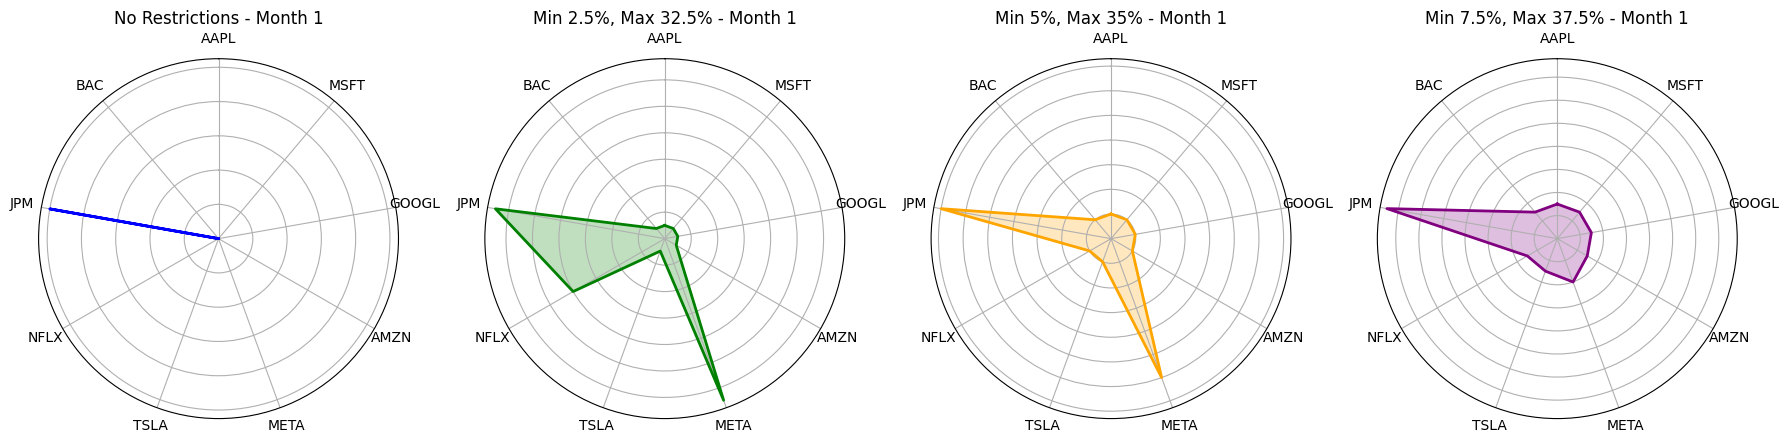

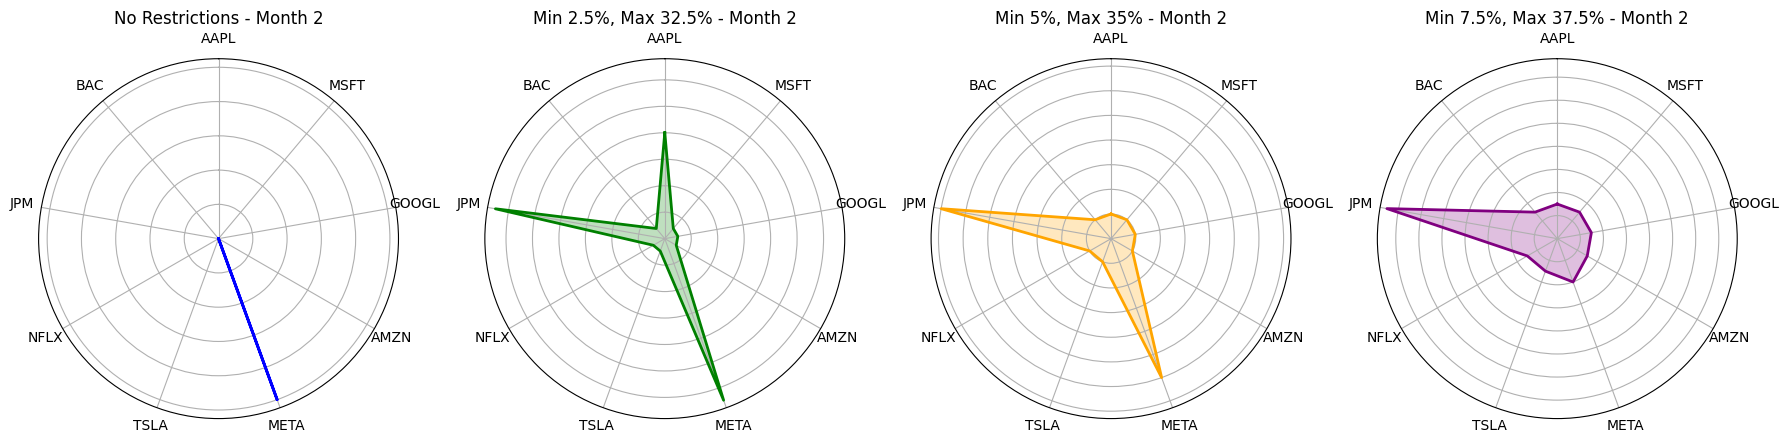

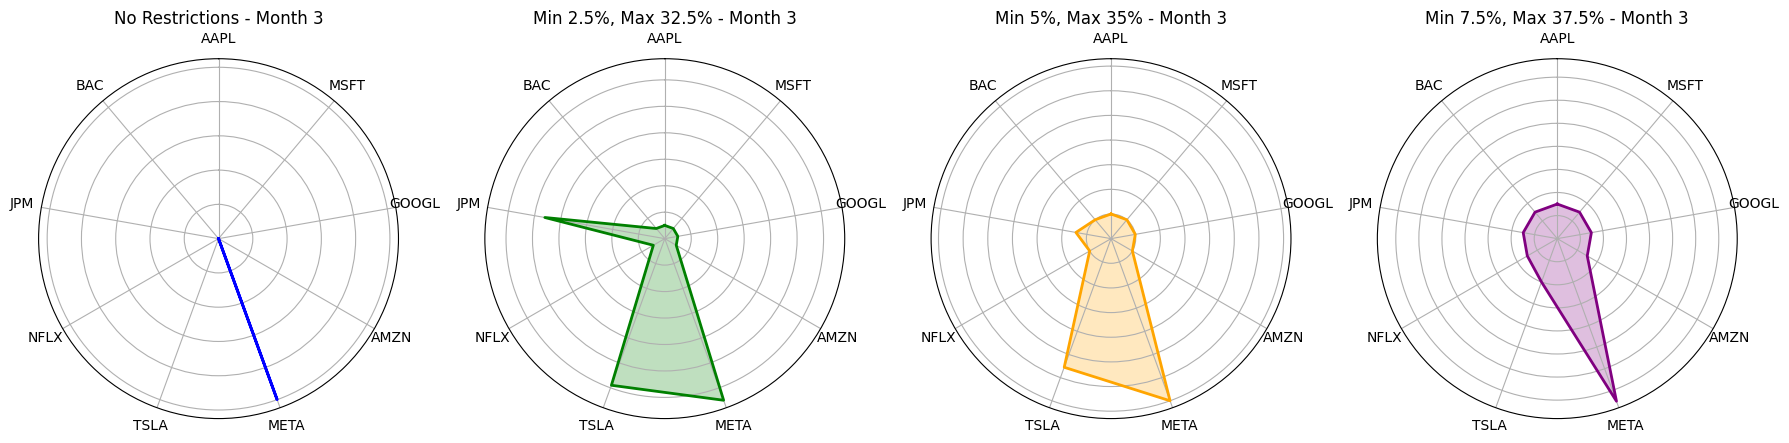

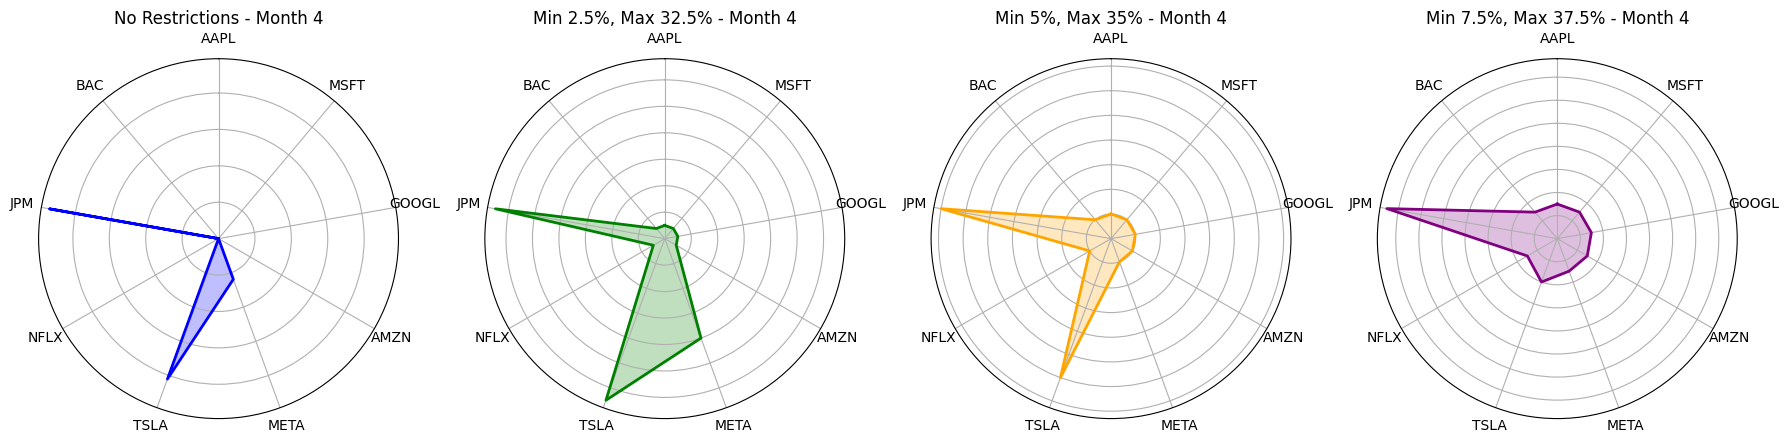

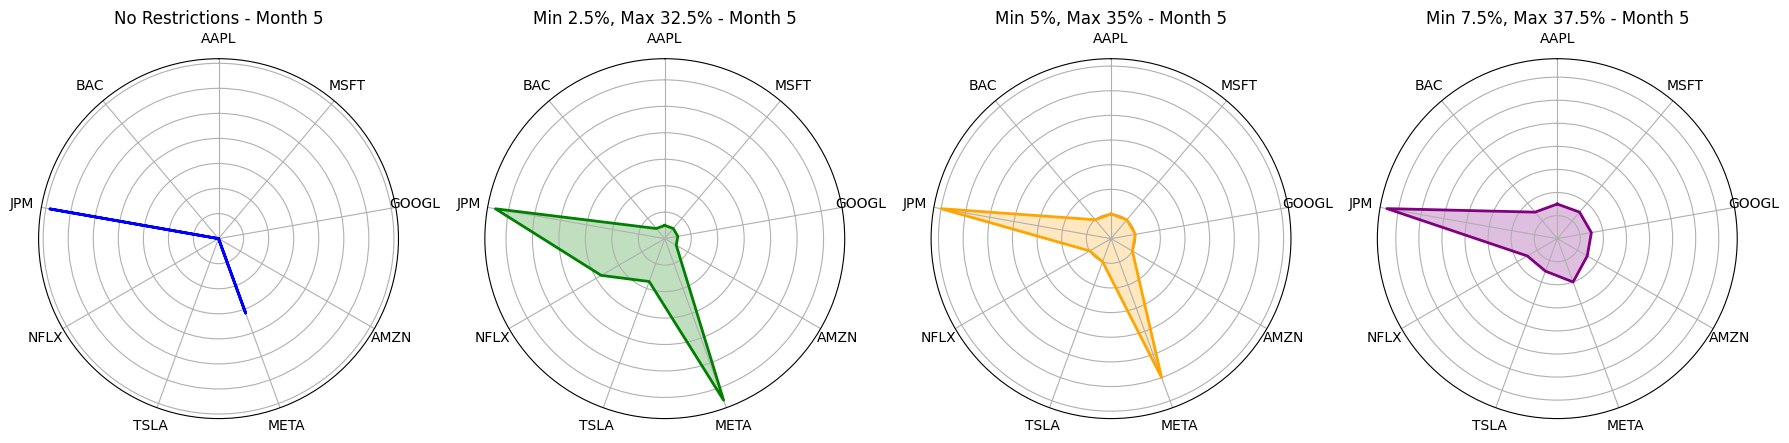

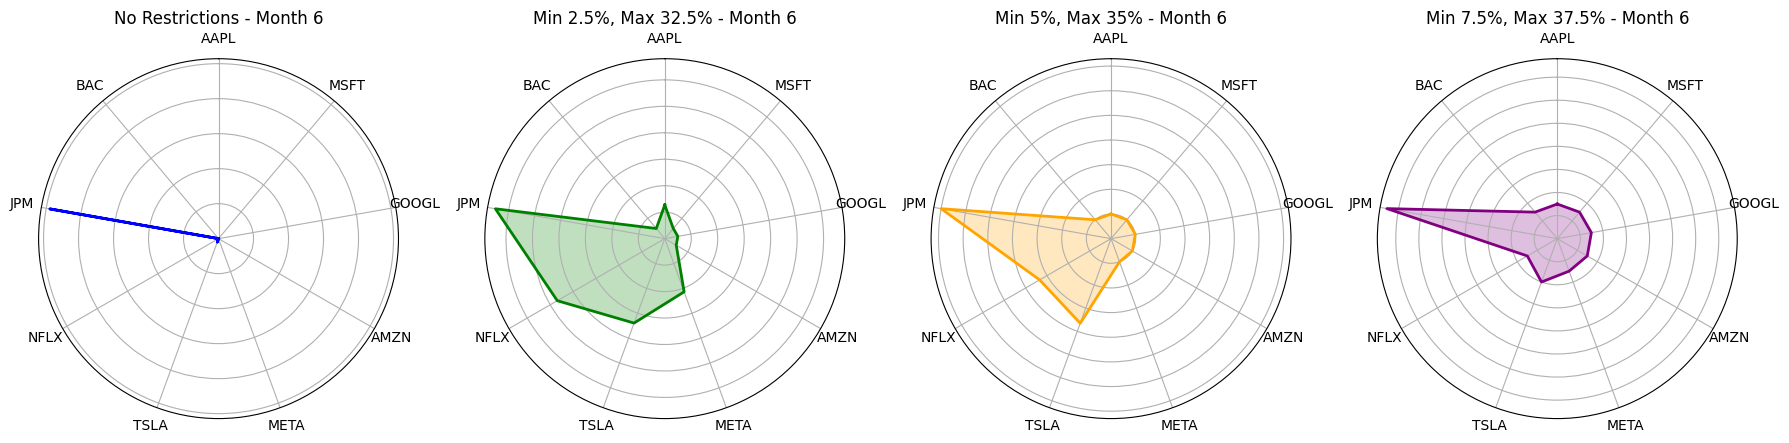

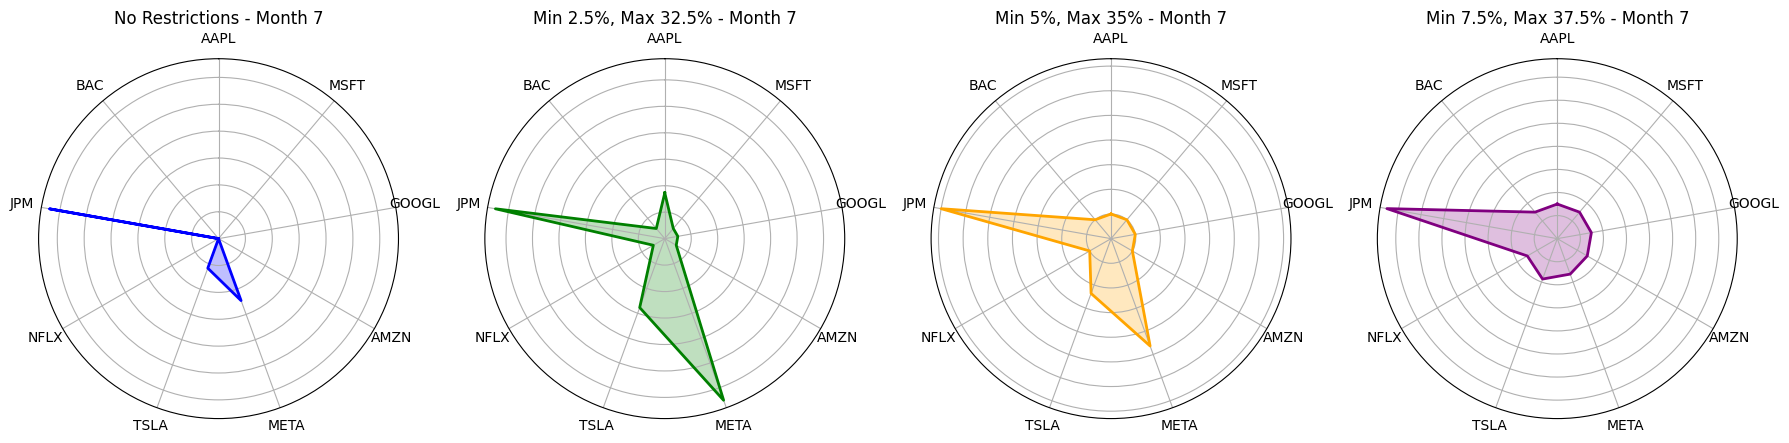

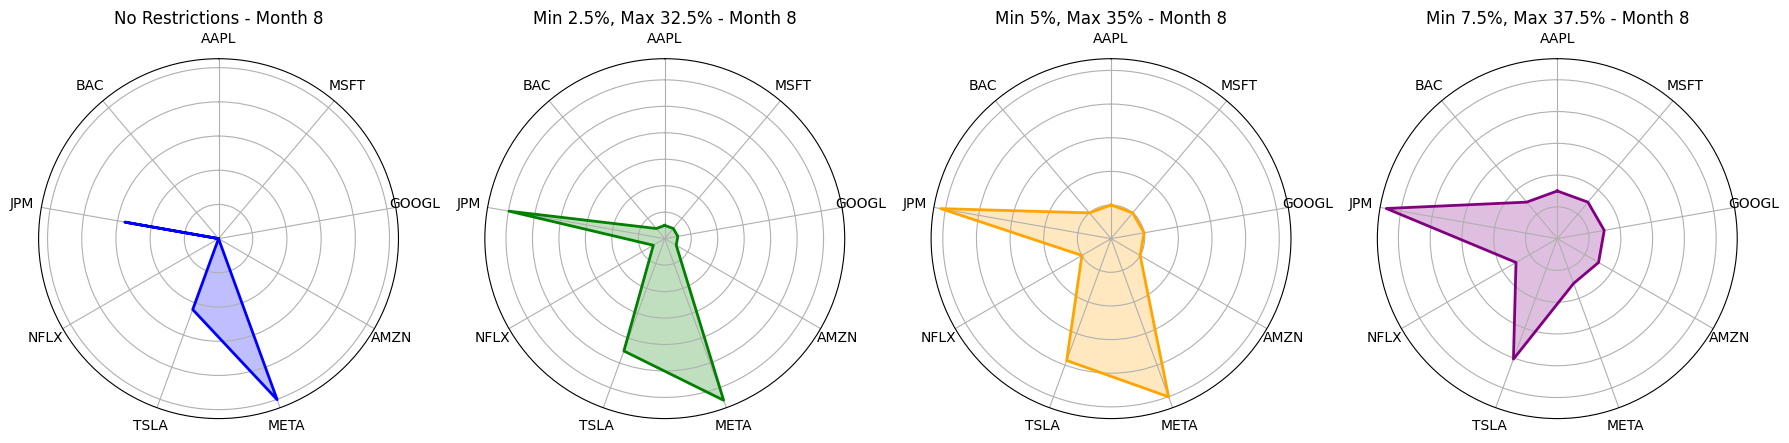

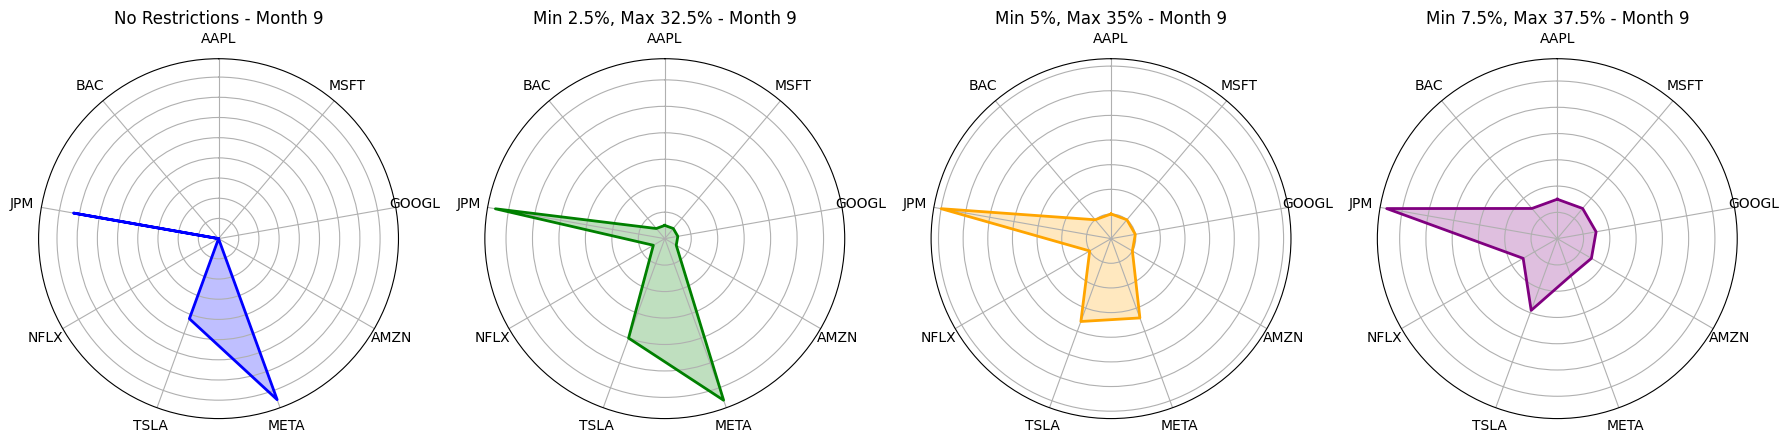

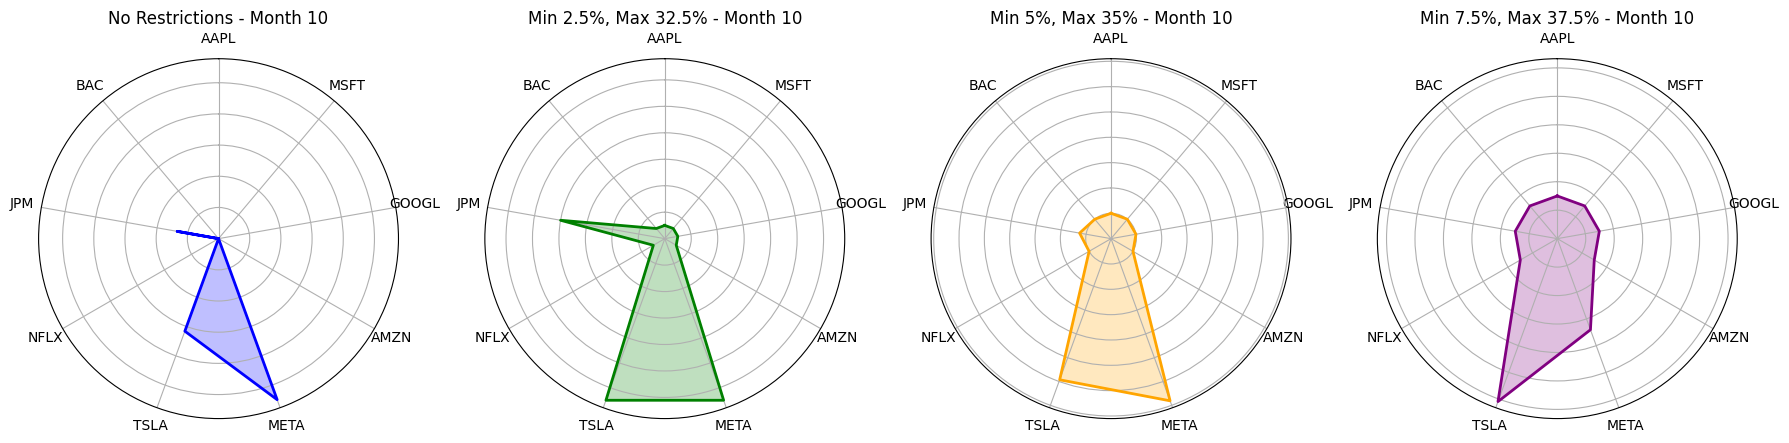

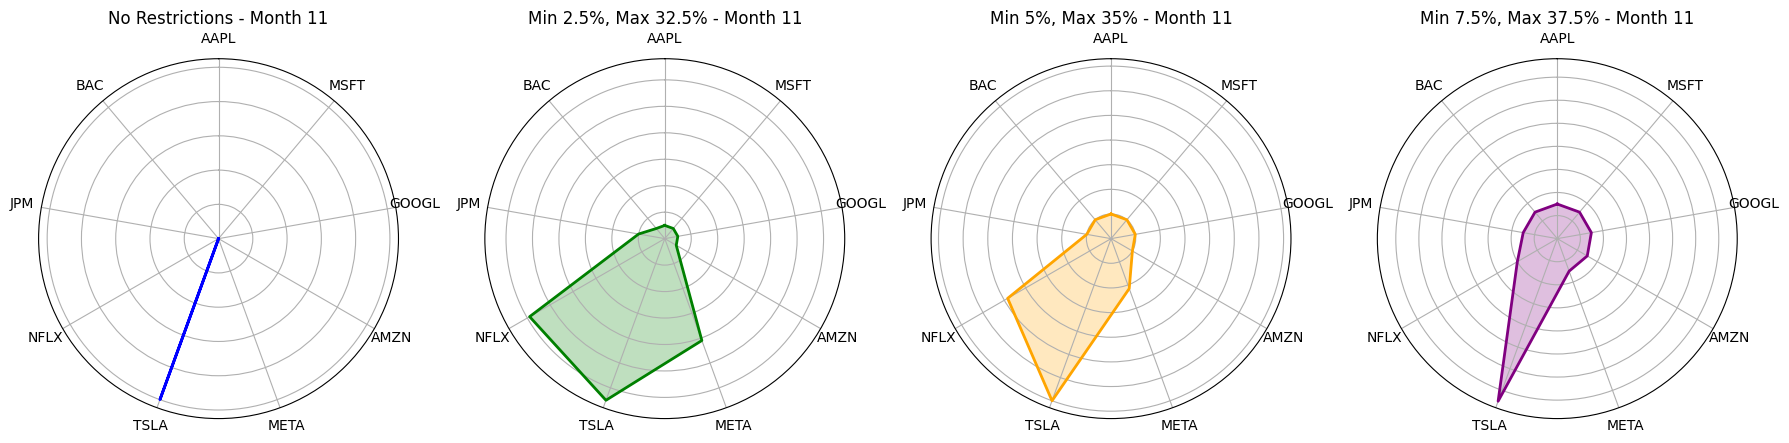

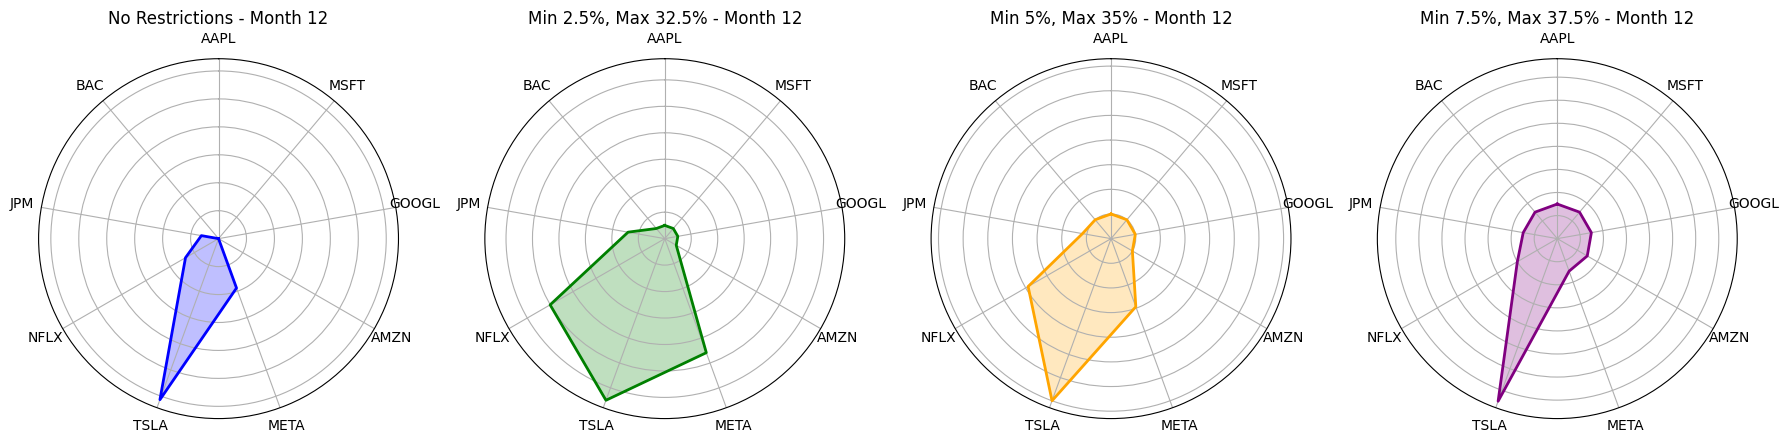

In [56]:
def plot_radar_all_portfolios(portfolios, month):
    """
    Plots radar charts for multiple portfolios, showing the allocation of assets for each portfolio.

    Inputs:
    - portfolios: Dictionary containing portfolio names as keys and optimized portfolio weights as values.
    - month: Integer representing the month for which the radar charts are being plotted.

    Output:
    - Displays radar charts showing asset allocation for each portfolio in the given month.
    """
    labels = tickers  # Asset labels for the radar chart (assumed to be predefined as tickers)
    num_vars = len(labels)  # Number of variables (assets) to plot
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]  # Calculate the angle for each asset
    angles += angles[:1]  # Complete the loop by adding the first angle at the end

    colors = ['blue', 'green', 'orange', 'purple']  # Define colors for each portfolio

    # Create subplots for each portfolio
    fig, axes = plt.subplots(1, len(portfolios), figsize=(18, 6), subplot_kw=dict(polar=True))

    for i, (name, portfolio) in enumerate(portfolios.items()):
        ax = axes[i]
        ax.set_theta_offset(pi / 2)  # Rotate the chart to start at the top
        ax.set_theta_direction(-1)  # Reverse the direction of the chart

        values = portfolio.x.tolist()  # Get the portfolio weights as a list
        values += values[:1]  # Close the loop by adding the first value at the end

        # Fill the radar chart with color and plot the outline
        ax.fill(angles, values, color=colors[i], alpha=0.25, label=name)
        ax.plot(angles, values, color=colors[i], linewidth=2)

        ax.set_yticklabels([])  # Remove the radial labels (for visual simplicity)
        ax.set_xticks(angles[:-1])  # Set the x-axis (angles) labels to the asset names
        ax.set_xticklabels(labels)

        # Set the title of the subplot for each portfolio
        ax.set_title(f'{name} - Month {month}')

    plt.tight_layout()  # Adjust layout to avoid overlapping charts
    plt.show()

# Plot radar charts for each month
for month, portfolios in portfolios_per_month.items():
    plot_radar_all_portfolios(portfolios, month)

# Comparing Returns and Risk-Adjusted Returns

In [57]:
# Initializing the dataframe to store the results
df_results = pd.DataFrame()

# Iterating over the monthly results and storing them in the dataframe
for month, perf in results.items():
    for name, data in perf.items():
        # Creating a temporary DataFrame for each entry and concatenating it to the main results DataFrame
        temp_df = pd.DataFrame({
            'Month': [month],
            'Portfolio': [name],
            'Returns': [data['Returns']],
            'Risk Adjusted Return': [data['Risk Adjusted Return']]
        })
        df_results = pd.concat([df_results, temp_df], ignore_index=True)

# Calculating the average returns and risk-adjusted returns by portfolio
df_mean_results = df_results.groupby('Portfolio').mean().reset_index().drop(columns='Month')

# Displaying the dataframe with the average returns and risk-adjusted returns
df_mean_results

,Portfolio,Returns,Risk Adjusted Return
0,Baseline,0.555101,2.904406
1,"Min 2.5%, Max 32.5%",0.470445,2.278442
2,"Min 5%, Max 35%",0.451451,2.096306
3,"Min 7.5%, Max 37.5%",0.451493,2.130726
4,No Restrictions,0.481802,1.407315


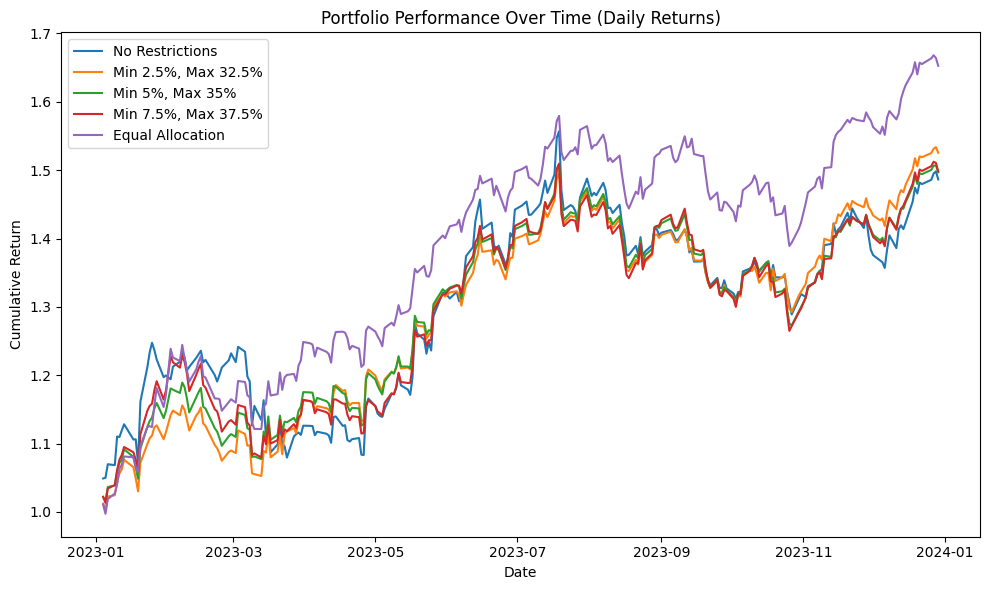

In [64]:
def plot_portfolio_performance_over_time(portfolios_per_month, price_data):
    """
    Plots the cumulative performance of portfolios over time based on daily returns.

    Inputs:
    - portfolios_per_month: Dictionary containing portfolios for each month.
    - price_data: DataFrame with price data for the assets used in the portfolios.

    Output:
    - A line plot showing the cumulative return for each portfolio over time.
    """
    # Prepare a dataframe to store daily cumulative returns for each portfolio
    portfolios_cumulative_returns = pd.DataFrame(index=price_data.index)

    # Initialize the starting value for each portfolio (100%)
    portfolios_last_value = {name: 1 for name in portfolios_per_month[1]}

    # Adding the equal allocation portfolio (evenly distributed weights)
    equal_allocation_weights = np.ones(price_data.shape[1]) / price_data.shape[1]
    portfolios_last_value['Equal Allocation'] = 1  # Starting also at 100%

    # Iterating over the months and applying the known allocations
    for month, portfolios in portfolios_per_month.items():
        start_date = pd.Timestamp(f'2023-{month:02d}-01')
        end_date = pd.Timestamp(f'2023-{month:02d}-01') + MonthEnd(1)

        # Filter price changes for the current month's time window
        month_data = price_data.loc[start_date:end_date]
        month_returns = month_data.pct_change().dropna()  # Calculate daily price changes (daily returns)

        # Calculating the cumulative daily returns for each portfolio
        for name, portfolio in portfolios.items():
            # Apply monthly allocations to daily returns and calculate cumulative daily returns
            daily_returns = (month_returns * portfolio.x).sum(axis=1)
            cumulative_returns = (1 + daily_returns).cumprod() * portfolios_last_value[name]  # Continue from the last month's final value

            portfolios_last_value[name] = cumulative_returns.iloc[-1]  # Update the last value for the next month

            if name not in portfolios_cumulative_returns.columns:
                portfolios_cumulative_returns[name] = cumulative_returns
            else:
                portfolios_cumulative_returns[name] = portfolios_cumulative_returns[name].combine_first(cumulative_returns)

        # Adding the equal allocation portfolio
        equal_daily_returns = (month_returns * equal_allocation_weights).sum(axis=1)
        equal_cumulative_returns = (1 + equal_daily_returns).cumprod() * portfolios_last_value['Equal Allocation']

        portfolios_last_value['Equal Allocation'] = equal_cumulative_returns.iloc[-1]  # Update last value for the next month

        if 'Equal Allocation' not in portfolios_cumulative_returns.columns:
            portfolios_cumulative_returns['Equal Allocation'] = equal_cumulative_returns
        else:
            portfolios_cumulative_returns['Equal Allocation'] = portfolios_cumulative_returns['Equal Allocation'].combine_first(equal_cumulative_returns)

    # Interpolating values between the end of one month and the start of the next
    portfolios_cumulative_returns.interpolate(method='linear', inplace=True)

    # Remove rows with only NaN values
    portfolios_cumulative_returns.dropna(how='all', inplace=True)

    # Add a row with 1 values before the first row (with date minus one day)
    first_valid_date = portfolios_cumulative_returns.index[0]
    new_first_date = first_valid_date - pd.Timedelta(days=1)

    # Insert a new row with 1.0 for all portfolios
    new_row = pd.Series(1.0, index=portfolios_cumulative_returns.columns, name=new_first_date)
    portfolios_cumulative_returns = pd.concat([pd.DataFrame([new_row]), portfolios_cumulative_returns])

    # Plotting a line chart for all portfolios over time
    plt.figure(figsize=(10, 6))
    for col in portfolios_cumulative_returns.columns:
        plt.plot(portfolios_cumulative_returns.index, portfolios_cumulative_returns[col], label=col)

    plt.title('Portfolio Performance Over Time (Daily Returns)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Running the function to generate the daily performance plot
plot_portfolio_performance_over_time(portfolios_per_month, price_data)